<a href="https://colab.research.google.com/github/paton838/works/blob/master/data-science/share_predict/share_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting Share Prices by Deep Learning Methods**

This notebook performs share price prediction of a company with the following steps:
- Gather live share price data from Yahoo Finance.
- Normalise the data.
- Train deep learning methods with 3 different solvers:
  - adam
  - rmsprop
  - adamax
- Compare the results and select the best solver.
- Plot the results.
- Predict the share prices of the future 5 days.
- Compare the results.

In [1]:
# inspired by https://www.youtube.com/watch?v=QIUxPv5PJOY
#
%tensorflow_version 1.x
import math
import numpy as np
import pandas as pd

import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
import datetime as dt
from datetime import datetime

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


Set the name of the share to predict.

In [0]:
share_name = 'AIR.NZ'

Load data from Yahoo Finance.

In [3]:
df = web.DataReader(share_name, data_source='yahoo', start='2005-01-01', end='2020-04-20')
print('Share price of {} the last 5 days:'.format(share_name))
print(df.tail())

Share price of AIR.NZ the last 5 days:
             High    Low   Open  Close      Volume  Adj Close
Date                                                         
2020-04-14  1.220  1.070  1.090  1.180  15953003.0      1.180
2020-04-15  1.320  1.185  1.190  1.315  12900018.0      1.315
2020-04-16  1.610  1.270  1.330  1.310  17252975.0      1.310
2020-04-19  1.545  1.350  1.400  1.390   8768526.0      1.390
2020-04-20  1.485  1.330  1.405  1.360   6864236.0      1.360


Plot the Price History.

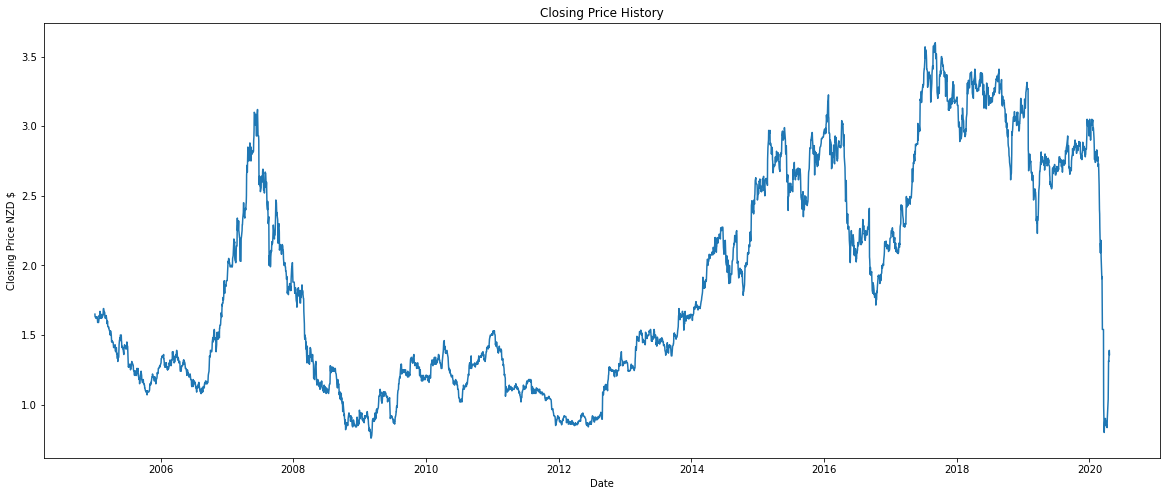

In [4]:
plt.figure(figsize=(20,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price NZD $')
plt.show()

Show the number of days of share prices gathered.

In [5]:
# get the Closing price column
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*0.8)

print("Number of days: {}".format(training_data_len))

Number of days: 3078


Normalise the data.

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# scaled_data

Specify the number of days in train dataset to use for deep learning model predictions.

In [0]:
# use past 100 days to get trends
n_days_use = 100

train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

# append each set of 'n_days_use' into x_train
for i in range(n_days_use, len(train_data)):
  x_train.append(train_data[i-n_days_use:i, 0])
  y_train.append(train_data[i, 0])

In [0]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(2978, 100, 1)


Set and train the models: adam, adamax, rmsprop.

In [10]:
model1 = Sequential()
model1.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model1.add(LSTM(50, return_sequences=False))
model1.add(Dense(25))
model1.add(Dense(1))

# using adam
# train model. best result = 0.08279703697189689
model1.compile(optimizer='adam', loss='mean_squared_error')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2.add(LSTM(50, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))

# using rmsprop
# train model. best result = 0.059735862305387855
model2.compile(optimizer='rmsprop', loss='mean_squared_error')

In [0]:
model3 = Sequential()
model3.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model3.add(LSTM(50, return_sequences=False))
model3.add(Dense(25))
model3.add(Dense(1))

# using adamax
# train model. best result = 0.07695954650019605
model3.compile(optimizer='adamax', loss='mean_squared_error')

Fit the models.

In [13]:
model1.fit(x_train, y_train, batch_size=1, epochs=1)
model2.fit(x_train, y_train, batch_size=1, epochs=1)
model3.fit(x_train, y_train, batch_size=1, epochs=1)


Epoch 1/1
2978/2978 [==============================] - 163s 55ms/step - loss: 0.0012
Epoch 1/1
2978/2978 [==============================] - 162s 54ms/step - loss: 0.0014
Epoch 1/1
2978/2978 [==============================] - 166s 56ms/step - loss: 0.0010


Specify the number of days in train dataset to use for deep learning model predictions.

In [0]:
# get the sets of 'n_days_use' to test
test_data = scaled_data[training_data_len - n_days_use: , :]

x_test = []
y_test = dataset[training_data_len: , :]
for i in range(n_days_use, len(test_data)):
  x_test.append(test_data[i-n_days_use:i, 0])

In [0]:
x_test = np.array(x_test)

In [0]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Calculate the Root Mean Square Error of each prediction model:
- The smaller the better

In [30]:
predictions_adam = model1.predict(x_test)
predictions_adam = scaler.inverse_transform(predictions_adam)
rmse1 = np.sqrt(np.mean(predictions_adam - y_test)**2)
rmse1

0.1697659844384857

In [31]:
predictions_rmsprop = model2.predict(x_test)
predictions_rmsprop = scaler.inverse_transform(predictions_rmsprop)
rmse2 = np.sqrt(np.mean(predictions_rmsprop - y_test)**2)
rmse2

0.06688907924647139

In [32]:
predictions_adamax = model3.predict(x_test)
predictions_adamax = scaler.inverse_transform(predictions_adamax)
rmse3 = np.sqrt(np.mean(predictions_adamax - y_test)**2)
rmse3

0.04893868378761996

It shows that the model with adamax has the best performance. 

Let's plot it to see the trend and how they match with the actual closing price:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

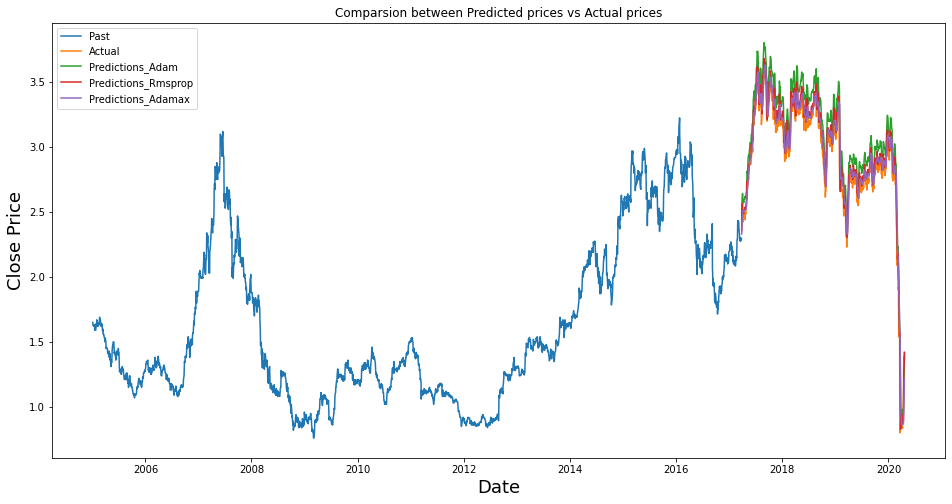

In [39]:
# plot to show the prediction and actual price
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions_Adam'] = predictions_adam
valid['Predictions_Rmsprop'] = predictions_rmsprop
valid['Predictions_Adamax'] = predictions_adamax

plt.figure(figsize=(16,8))
plt.title('Comparsion between Predicted prices vs Actual prices')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions_Adam', 'Predictions_Rmsprop', 'Predictions_Adamax']])
plt.legend(['Past', 'Actual', 'Predictions_Adam', 'Predictions_Rmsprop', 'Predictions_Adamax'], loc='upper left')
plt.show()

The chart above has too much data in it, which makes it hard to see the comparsion between the actual vs predicted prices. 

Let's plot it again with only the dates with predicted values:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

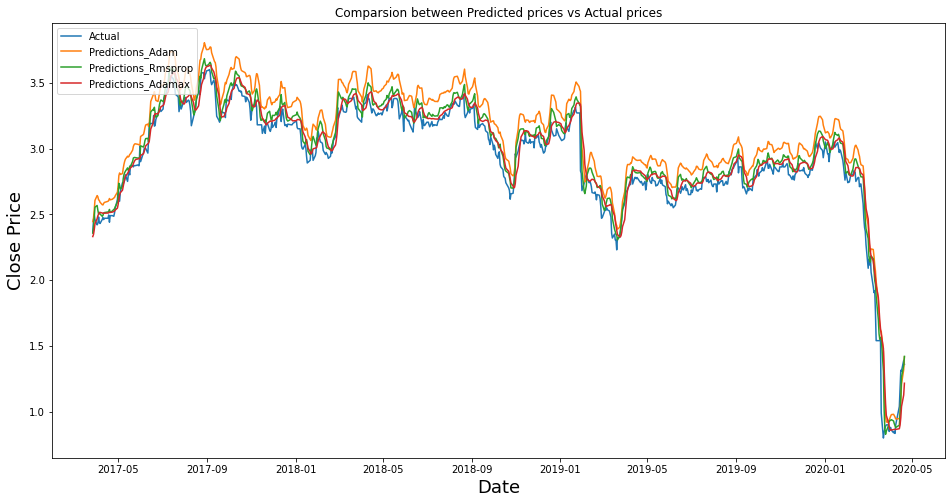

In [40]:
# plot to show the prediction and actual price
valid = data[training_data_len:]
valid['Predictions_Adam'] = predictions_adam
valid['Predictions_Rmsprop'] = predictions_rmsprop
valid['Predictions_Adamax'] = predictions_adamax

plt.figure(figsize=(16,8))
plt.title('Comparsion between Predicted prices vs Actual prices')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(valid[['Close', 'Predictions_Adam', 'Predictions_Rmsprop', 'Predictions_Adamax']])
plt.legend(['Actual', 'Predictions_Adam', 'Predictions_Rmsprop', 'Predictions_Adamax'], loc='upper left')
plt.show()

This chart shows that the red line (adamax) and green line (resprop) are clearly closer matches with the blue line (actual price). This proofs that the rmse value calculated above is correct.


**Prediction of the future days**

The following sections will focus on applying the model to predict the future prices:

In [0]:
# Now, let's try to make some prediction of future days:
#=====================
# get the  quote
quote = df

Let's define some functions to steamline the prediction process:

In [0]:
#Create a new dataframe with only Close price
new_df = quote.filter(['Close'])

def predict_(df, model, n_days_use_=100):
  """ predict the price with a given df, and n_days_use (100 days by default). """
  # #Get the last n day closing price values and convert the dataframe to an array
  last_n_days = df[-n_days_use_:].values

  #Scale the data to be values between 0 and 1
  last_n_days_scaled = scaler.transform(last_n_days)
  #Create an empty list
  X_test = []
  #Append the past n days
  X_test.append(last_n_days_scaled)
  #Convert the X_test data set to a numpy array
  X_test = np.array(X_test)

  #Reshape the data
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  #Get the predicted scaled price
  pred_price = model.predict(X_test)

  #undo the scaling 
  pred_price = scaler.inverse_transform(pred_price)

  return pred_price

In [0]:
def print_ht(df, num):
  """ 
    Print the number of top and bottom items of df. 
    df: DataFrame to be printed
    num: Number of items to be printed out on head and tail
  """
  print(df.head(num))
  print(df.tail(num))

In [0]:
def get_prediction_value(df_to_predict, model):
  """ 
    Get the values from the prediction df. 
    df_to_predict: Dataframe to be used to get the predicted values.
  """
  return predict_(df_to_predict, model)[0][0]

In [0]:
def predict_append(df_a, model, n_days):
  """ 
    Append new data to the df, with n_days of future days to be predicted. 
    df_a: Dataframe with training values.
    n_days: num of future days to be predicted.
  """
  turn0_index = -1
  turn0_date = ''
  for i in range(n_days):
    # get new prediction
    new_prediction = get_prediction_value(df_a, model)

    # get the date of the next date
    next_date = pd.to_datetime( df_a.index[-1] + timedelta(days=1) ).date()
    # print(f'New date: {next_date}. Predicted price: {new_prediction}. ')

    # update df_a
    new_row = pd.DataFrame({'Close': new_prediction}, index=pd.to_datetime([next_date]))
    df_a = df_a.append(new_row)
    if (new_prediction <= 0) & (turn0_index == -1):
      turn0_index = i
      turn0_date = next_date
      # print(f'Turn 0 here::: Index: {turn0_index}, Date: {turn0_date}')
  return {'data':df_a, 'turn0': [turn0_index, turn0_date]}

**Make a prediction of the next 5 days:**

In [65]:
# try predicting the next 5 days
days_to_predict = 5
model_to_use = model3;

predicted_future = predict_append(new_df, model_to_use, days_to_predict)
predicted_days = ( predicted_future )['data'].iloc[-days_to_predict:, :]

print("Share price of {} on the future {} days from the data we obtained.".format(share_name, days_to_predict))
print(predicted_days)
print(predicted_days.shape)

# print(list(predicted_future)[:])
# (predicted_future)

# to print out the day that it's predicted to reach 0
# print(f'Date turn 0: {predicted_future["turn0"][0]}, {predicted_future["turn0"][1]}')

Share price of AIR.NZ on the future 5 days from the data we obtained.
               Close
2020-04-21  1.289873
2020-04-22  1.333429
2020-04-23  1.360188
2020-04-24  1.377402
2020-04-25  1.389114
(5, 1)


Plot the future prices:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


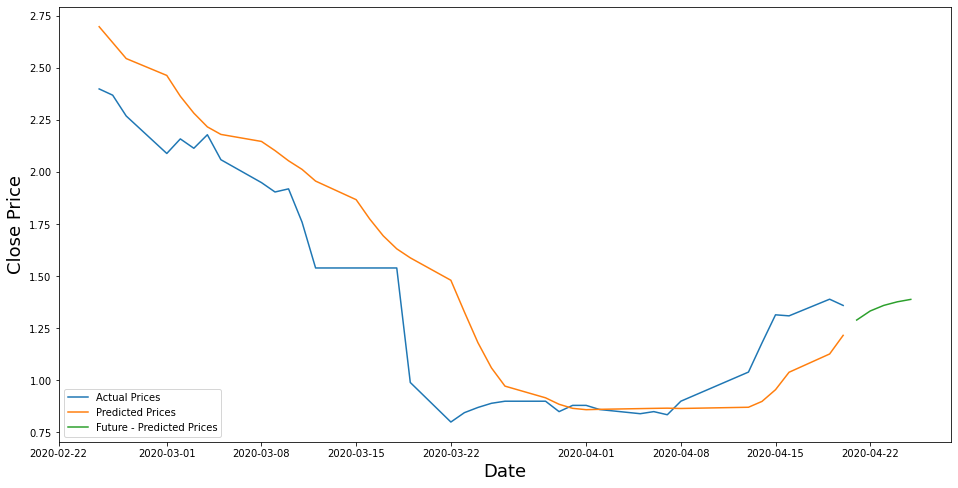

In [68]:
# Let's show the data on a chart:
predictions = predictions_adamax

# the actual prices. show only the latest 5% data.
valid = data[training_data_len + math.ceil(len(predictions) * 0.95):]

# the predicted prices of the past days. show only the latest 5% data.
valid['Predictions'] = predictions[math.ceil(len(predictions) * 0.95):]

# the predicted prices of the future days
future = predicted_days

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
# plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(future['Close'])

## if the predicted price ever goes below 0
# plt.annotate(f'Turn 0 @{predicted_future["turn0"][1]}!', xy=[predicted_future["turn0"][1], 0]
#               , xytext=(pd.Timestamp('2019-01-01'), 0.5)
#               , arrowprops={'arrowstyle':'->', 'color':'red'})

# plt.legend(['Train', 'Val', 'Predictions', 'Future'], loc='lower left')
plt.legend(['Actual Prices', 'Predicted Prices', 'Future - Predicted Prices'], loc='lower left')
plt.show()

comparsion between the predicted prices and the actual prices

In [69]:
future

,Close
2020-04-21,1.289873
2020-04-22,1.333429
2020-04-23,1.360188
2020-04-24,1.377402
2020-04-25,1.389114


The actual prices of the last few days (excluding weekends and public holidays)

In [73]:
quote2 = web.DataReader(share_name, data_source='yahoo', start='2020-04-22', end='2020-04-28')
print(quote2['Close'])

Date
2020-04-21    1.275
2020-04-22    1.280
2020-04-23    1.205
2020-04-27    1.255
2020-04-28    1.305
Name: Close, dtype: float64
